In [2]:
import pandas as pd
import sqlite3 as sql
import numpy as np

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [3]:
places_df = pd.read_csv('../data/foursquare_bikes.csv')
stations_df = pd.read_csv('../data/berlin_bikes.csv')

# We will have to join on places_df.origin and a new column in stations_df of lat+','+long
stations_df['origin'] = stations_df['lat'].astype(str) + ',' + stations_df['long'].astype(str)
stations_df = stations_df.drop(['lat','long','Unnamed: 0'], axis=1)

places_df = places_df.drop('Unnamed: 0',axis=1)
places_df['origin'] = places_df['origin'].astype(str)
stations_df['origin'] = stations_df['origin'].astype(str)

In [4]:
places_df.head(1)

,name,distance_meters,category,popularity,rating,lat,long,origin
0,Curry Wolf,29.0,Fast Food Restaurant,0.903641,7.8,52.503902,13.335662,"52.504157,13.335328"


In [5]:
stations_df.head(1)

,bikes_available,bikes_in_use,total_bikes,origin
0,4,0,4,"52.504157,13.335328"


Now that we have two 'Origin' columns we can join them.

In [6]:
bike_poi_df = pd.merge(places_df,stations_df,on='origin')

In [7]:
bike_poi_df.head(10)

,name,distance_meters,category,popularity,rating,lat,long,origin,bikes_available,bikes_in_use,total_bikes
0,Curry Wolf,29.0,Fast Food Restaurant,0.903641,7.8,52.503902,13.335662,"52.504157,13.335328",4,0,4
1,Pull&Bear Ber-Tauentzienstrasse,29.0,Clothing Store,0.988963,7.8,52.504021,13.335963,"52.504157,13.335328",4,0,4
2,Levi Strauss Germany GmbH,19.0,Clothing Store,0.936147,6.7,52.504051,13.334821,"52.504157,13.335328",4,0,4
3,Commerzbank,13.0,Bank,0.995382,6.0,52.504245,13.334703,"52.504157,13.335328",4,0,4
4,Curry Am Ku'damm,10.0,Snack Place,0.781733,NaN,52.504211,13.334964,"52.504157,13.335328",4,0,4
5,Ferri`s Ristorante,13.0,Italian Restaurant,0.970388,5.5,52.504004,13.334877,"52.504157,13.335328",4,0,4
6,Peter Pane BURGERGRILL - BAR,31.0,Bar,0.979920,NaN,52.503802,13.335669,"52.504157,13.335328",4,0,4
7,Allgemeine Beamten Kasse Kreditbank,36.0,Bank,0.386057,NaN,52.503636,13.335423,"52.504157,13.335328",4,0,4
8,Zaddy's,42.0,Diner,0.978734,5.9,52.504071,13.336463,"52.504157,13.335328",4,0,4
9,Mode&Schmuck 24 GmbH,41.0,NaN,0.249345,NaN,52.504252,13.334806,"52.504157,13.335328",4,0,4


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [ ]:
# This is by far the one I had the most fun with and it provides excellent easily digestible context for the data.
# plotly.express has a really cool feature where you can scatter plots onto a detailed interactive map.

import plotly.express as px
tmp_stations_df = pd.read_csv('../data/berlin_bikes.csv')
# set x and y
x = tmp_stations_df['lat']
y = tmp_stations_df['long']

fig = px.scatter_mapbox(tmp_stations_df,lat=x,lon=y,zoom=10,height=1000,width=1600,color='total_bikes',size='bikes_in_use', opacity=1)
#                       df we're using, x,      y   ------self explanitory-------- set gradient and size for spectrum of values in set column.
fig.update_layout(mapbox_style='open-street-map')
fig.show()

# This first plot is pretty basic. we're just plotting the location of every station, darker colored stations have fewer bikes and brighter stations have more bikes. Smaller stations have fewer bikes being used and larger have more.

![image not loaded](https://media.discordapp.net/attachments/1063653051602321462/1069017577587757129/map_1.PNG?width=1153&height=661)

From this first plot there's quite a few patterns we can pick out.
* In the city center there's low total bike stations distributed in a dense grid pattern. In a lot of the city there's one on every corner.
* The biggest bike stations are most often by parks/nature or plazas/old city shopping centres. Parks and Nature paths aren't picked up in the foursquares search so there's some neglect of relevant information there.
    * The north east station in the park by the campus is massive and very busy. The other bike stations, especially by the dorms are also busy.
    * In the heart of Berlin (GeorgenStrase) There's a big, very busy, bike station that likely has a route along the river. This is probably a big tourist spot.
    * However in the west, out of the city, there's a large park called Grunewald that isn't that popular for biking. I wonder why that is. Could this be used more by locals and not tourists?
* While the outskirts of Berlin don't have a lot of stations there's some locality's that have quite a few. This presents a pattern in their growth out of mostly a residential community of Berlin into more of a little city of its own. (Tegel, Rummelburg and furthest away is Hellendorf).

In [ ]:
tmp_places = places_df
# split origin (station lat long) into two columns to it's easier to set x and y.
tmp_places[['new_lat', 'new_long']] = places_df['origin'].str.split(',', expand=True)

# filter for stations that were unable to find places of interest in a 200m radius
no_poi = tmp_places[pd.isna(tmp_places['lat'])]

# set x and y
x = no_poi['new_lat']
y = no_poi['new_long']
x = x.astype(float)
y = y.astype(float)
# origin is a string, they need to be floats.

# basic plot                                                                           make all plots bright red
fig = px.scatter_mapbox(no_poi,lat=x,lon=y,zoom=10,height=1000,width=1600, opacity=0.8,color_discrete_sequence=['red'])
fig.update_layout(mapbox_style='open-street-map')
#                 increase size
fig.update_traces(marker={'size': 15})
fig.show()

![image not loaded](https://cdn.discordapp.com/attachments/1063653051602321462/1069022258758168736/image.png)

This marks all stations that were unable to return a POI in a 200m radius. Zooming in on them we can see a lot of them are in residential areas, a good amount are by parks/nature, and a couple are by academic areas/housing.

Compare the northwest Buch campus cluster in this map to the previous. In this map the north eastern most large, active dot is missing. This is because to the north of the campus there's all sorts of shopping and businesses.

Considering the north west point in the campus cluster is the biggest, most active station in the dataset. It's alarming that these connections are completely neglected.

For now I'm going to assign the category in each of these instances to 'residential/recreational' I've thought about adding ~5 rows for each instance to give this new category more weight over the dataset. If a station was by a bunch of clothing stores then rows with the category 'clothing' would be added x amount of times populating the database a ton with this category. For now I will leave it to one row per station though. I think this could be fine since this new category also implies isolation which will convey its own weight if that makes sense.

(At this zoom level these dots are also about the size of the area they are scanning)

In [20]:
bike_poi_df['category'] = bike_poi_df['category'].where(bike_poi_df['lat'].notna(), 'residential/recreation')

In [21]:
bike_poi_df[bike_poi_df['category'] == 'residential/recreation'].count()
# It worked

name                0
distance_meters     0
category           37
popularity          0
rating              0
lat                 0
long                0
origin             37
bikes_available    37
bikes_in_use       37
total_bikes        37
dtype: int64

On this topic there's a lot more categories that are na.

In [12]:
bike_poi_df[pd.isna(bike_poi_df['category'])].head()


,name,distance_meters,category,popularity,rating,lat,long,origin,bikes_available,bikes_in_use,total_bikes
9,Mode&Schmuck 24 GmbH,41.0,NaN,0.249345,NaN,52.504252,13.334806,"52.504157,13.335328",4,0,4
18,Albig Becker Entezami Gasiorek-wiens Knoll,33.0,NaN,NaN,NaN,52.504443,13.335464,"52.504157,13.335328",4,0,4
70,Balfanz Ingo - SUBSTANZFINANZ - Berlin,51.0,NaN,NaN,NaN,52.496980,13.291967,"52.496986,13.29121",0,4,4
75,Hermes PaketShop,52.0,NaN,NaN,NaN,52.497458,13.291179,"52.496986,13.29121",0,4,4
78,Lotus Blumen,55.0,NaN,NaN,NaN,52.497476,13.291048,"52.496986,13.29121",0,4,4


There's 6277, that's about %13 of our data.

Googling the names I immediatley found a pattern where these are a lot of headquarters/offices for companies that don't have much of a public presence. for example I translated this description of one.

'The acquisition, holding and management of real estate projects, in particular the property Junckersstrasse 35/36 in Dessau and all related transactions... '

There's really no need for them to have much of an internet presence other than a public address so the clients they do have / new employees or whoever can find their office / headquarters.

I could rename all these categories to 'private' but I worry about how much weight it would have.

The most popular category for example is 'Business and Professional Services' at 2987.

Changing ~6200 rows category to the same thing would really harm it. Especially when a lot of the businesses can be sorted into more specific categories that are very different from eachother.

For now I'm going to leave them alone. They still bring meaningful value to the dataset because they're tied to the station closest to them and will be included in a count.

I can also always clone this df and make changes to these NaN categories if I want to. One idea is to spend a bit more time googling them and find the most common categories they fall under then name a fraction of them each category. It would harm the relevance of the lat and long but could be useful in some other scenarios.

In [ ]:
# Now that that tangent is done this is the last example I'll do of this map I love.
# Here we are plotting the overlap of POIs
places_grouped = places_df.groupby(['lat', 'long']).size().reset_index(name='counts')
x = places_grouped['lat']
y = places_grouped['long']

fig = px.scatter_mapbox(places_grouped,lat=x,lon=y,zoom=10,height=1000,width=1600,color='counts',size='counts', opacity=0.6)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

![failed to load](https://cdn.discordapp.com/attachments/1063653051602321462/1069049057827377233/image.png)

In this plot both the size and color of the marker is tied to how frequently it occurs in the dataframe.

I chose a much smaller radius of 200m instead of the recommended 1km. This is because when using the yelp and foursquare api you can not, as far as I know, return POI search results ordered by how close they are to the given lat and long. Instead it just returns the first 50 it finds that are in the radius.

Look at the big yellow dot in the South-East city center. This must be a place that is evaluated very early. If our radius was higher this point would occur very very frequently even for stations that are as far away as possible.

Here is another way to interpret how results are being returned and causing overlay (this is not actually what is running on their end, a dumbed down SQL query just communicates it well)
```SQL
SELECT * FROM poi_table WHERE distance < radius LIMIT 50
```
Vs what I would prefer to have return
```SQL
SELECT * FROM poi_table WHERE distance < radius ORDER BY distance LIMIT 50
```

Take a quick look at [this land use map of Berlin.](https://lichfields.uk/media/4109/berlin-land-use-map-extract.jpg)

The size of our radius fits pretty well within these zones so I'm confident even in the instances where there is significant overlap it will still be representative of the zone it's in.

All in all I think 200m is right in the goldilocks zone for my radius. Only a tiny percentage of stations weren't able to detect a POI and when we investigated it we found meaningful information out of it. Of the other stations they were all able to grab POIs that were meaningful to their location without stepping on the other bike stations toes too much.

The large circles also show us a pattern in developement. There's many areas (often by water or parks) where there's a good amount of bike stations but not really any POIs meaning that the bike stations / trails are the POIs!

In [14]:
import os
import requests
from PIL import Image
import io
key = os.environ['TOMTOM_KEY']

In [30]:
# relative relative0 absolute reduced-sensitivity   // 11 zoom - 11/1100/671 // zoom in one step more - 12/2200/1343
url = 'https://api.tomtom.com/traffic/map/4/tile/flow/relative0/12/2200/1343.png?key='+key
response = requests.get(url).content
in_memory_file = io.BytesIO(response)
im = Image.open(in_memory_file)
im.show()
# Images generated when it was 12:34pm in Berlin
# This is a neat traffic flow api I found. It took quite a bit of fiddling around but it can provide some neat insights into the areas of Berlin with the worst traffic and how much bikes are utilized there.

<AxesSubplot:>

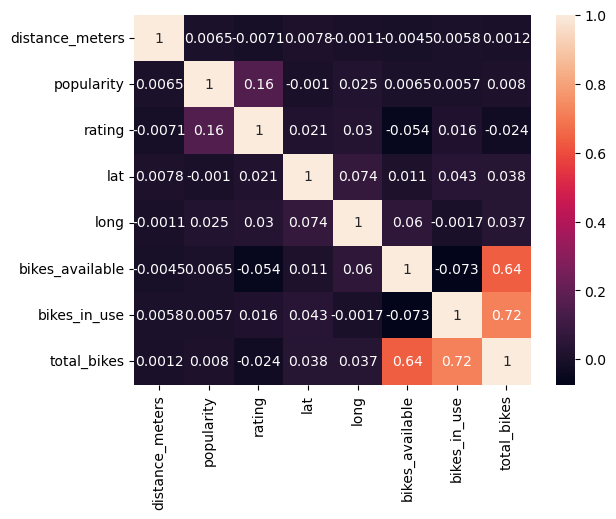

In [16]:
import seaborn as sns
fig = bike_poi_df.corr()
sns.heatmap(fig,annot=True)

![failed to load](https://cdn.discordapp.com/attachments/1063653051602321462/1069058131239387156/image.png)

Finally and very quickly here's my correlation heatmap. There isn't a lot to right home about here.

I was hoping there would be a stronger correlation between lat/long and total_bikes because there is a pattern where near the city center there's more bike stations but they have less bikes (usually 4) and then further out there's less stations with more bikes. There are some stations in the heart of Berlin with tons of bikes to them so I guess that throws that off.

In [17]:
bike_poi_df.to_csv('../data/joined_bikes.csv')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [18]:
conn = sql.connect('../data/bike_poi.db')

In [ ]:
bike_poi_df.to_sql('station_and_poi',conn,index=False)

In [ ]:
SELECT * FROM station_and_poi

It works


Look at the data before and after the join to validate your data.

Here is the output from my SQL query:
![failed to load](https://cdn.discordapp.com/attachments/1063653051602321462/1069060650522906724/image.png)
Here is the output from the pandas dataframe:
![failed to load](https://cdn.discordapp.com/attachments/1063653051602321462/1069061524326457395/image.png)

We did a left join where the df with all of the places was the left df and the df with the stations and bike info was the right df. We joined on 'Origin' which is the lat and long of the station / the origin of the radius it scanned in. Now for every single POI we have some info about the station it's associated with.

The left df and the new df have the same rows and the origin is relevant to the lat and long.

We can be very confident these two tables have joined successfully.